# Test the api

In [1]:
import pandas as pd
import plotly.express as px
import requests

In [2]:
import sys
import os
 
# getting the name of the directory
# where the this file is present.
current = os.getcwd()
 
# Getting the parent directory name
# where the current directory is present.
parent = os.path.dirname(current)
 
# adding the parent directory to
# the sys.path.
sys.path.append(parent)
import wgs84_ch1903

In [3]:
resources = {
    '2023': '4492d891-a366-49b9-b0f2-fabaa8015d47',
    '2022': 'bc2d7c35-de13-45e9-be21-538d9eab3653',
    '2021': 'b2b5730d-b816-4c20-a3a3-ab2567f81574',
}

In [4]:
url = '''https://data.stadt-zuerich.ch/api/3/action/datastore_search_sql?sql=
SELECT 
    "MSName",
    "ZSName",
    "EKoord",
    substring("EKoord", 2, 10) as ekoord_strip,
    "NKoord",
    substring("NKoord", 2, 10) as nkoord_strip,
    "Richtung",
    "AnzFahrzeuge",
    "AnzFahrzeugeStatus",
    REPLACE("MessungDatZeit",'T',' ') as "MessungDatZeit"
    from "{resource}"
WHERE REPLACE("MessungDatZeit",'T',' ')::DATE = '{date}'
AND "AnzFahrzeuge" IS NOT NULL
--LIMIT 1000
;'''

In [6]:
date = '2022-01-03'
year = date[0:4]

print(url.format(date=date, resource=resources[year]))

https://data.stadt-zuerich.ch/api/3/action/datastore_search_sql?sql=
SELECT 
    "MSName",
    "ZSName",
    "EKoord",
    substring("EKoord", 2, 10) as ekoord_strip,
    "NKoord",
    substring("NKoord", 2, 10) as nkoord_strip,
    "Richtung",
    "AnzFahrzeuge",
    "AnzFahrzeugeStatus",
    REPLACE("MessungDatZeit",'T',' ') as "MessungDatZeit"
    from "bc2d7c35-de13-45e9-be21-538d9eab3653"
WHERE REPLACE("MessungDatZeit",'T',' ')::DATE = '2022-01-03'
AND "AnzFahrzeuge" IS NOT NULL
--LIMIT 1000
;


In [7]:
# functions
def download_data(url):
    r = requests.get(url)
    df=pd.read_json(r.text,)
    if df['success'].unique()==True:
        error_status = False
        return (error_status,df)
    else:
        error_status = True
        return (error_status,df['error'])

def extract_data(df):
    # extract relevant data
    df2= df.loc['records','result']
    df3=pd.DataFrame.from_dict(df2)
    return df3

def convert_lat(row):
    return converter.CHtoWGSlat(row['ekoord_strip'],row['nkoord_strip'])

def convert_lon(row):
    return converter.CHtoWGSlng(row['ekoord_strip'],row['nkoord_strip'])

def data_preparation(df):
    df['Zeit']=df['MessungDatZeit']
    df['Uhrzeit'] = pd.to_datetime(df['Zeit']).dt.time.astype(str)
    df['MessungDatZeit'] = pd.to_datetime(df['MessungDatZeit'])
    df['ekoord_strip'] = df['ekoord_strip'].astype(float)
    df['nkoord_strip'] = df['nkoord_strip'].astype(float)
    df['AnzFahrzeuge'] = df['AnzFahrzeuge'].astype(float)
    df['stunde'] = df['MessungDatZeit'].dt.hour
    # convertiere Koordinaten
    df['lat'] = df.apply(convert_lat, axis=1)
    df['lon'] = df.apply(convert_lon, axis=1)
    return df
#preparations
# coordinate conversion
converter = wgs84_ch1903.GPSConverter()

In [8]:
error_status, df = download_data(url.format(date=date, resource=resources[year]))
if error_status == False:
    # no error
    miv_data = extract_data(df)
else:
    pass

miv_data = data_preparation(miv_data)
miv_data

NKoord      EKoord     MSName AnzFahrzeugeStatus      Richtung  \
0      1243936.2  2683009.89  Unbekannt           Gemessen      auswärts   
1      1243936.2  2683009.89  Unbekannt           Gemessen      auswärts   
2      1243936.2  2683009.89  Unbekannt           Gemessen      auswärts   
3      1243936.2  2683009.89  Unbekannt           Gemessen      auswärts   
4      1243936.2  2683009.89  Unbekannt           Gemessen      auswärts   
...          ...         ...        ...                ...           ...   
4123  1250615.65   2682704.5  Unbekannt           Gemessen  Bucheggplatz   
4124  1250615.65   2682704.5  Unbekannt           Gemessen  Bucheggplatz   
4125  1250615.65   2682704.5  Unbekannt           Gemessen  Bucheggplatz   
4126  1250615.65   2682704.5  Unbekannt           Gemessen  Bucheggplatz   
4127  1250615.65   2682704.5  Unbekannt           Gemessen  Bucheggplatz   

          MessungDatZeit  AnzFahrzeuge  nkoord_strip  \
0    2022-01-03 00:00:00          35.0     243936.20   
1    2022-01-03 01:00:00          29.0     243936.20   
2    2022-01-03 02:00:00          11.0     243936.20   
3    2022-01-03 03:00:00           6.0     243936.20   
4    2022-01-03 04:00:00           9.0     243936.20   
...                  ...           ...           ...   
4123 2022-01-03 19:00:00         302.0     250615.65   
4124 2022-01-03 20:00:00         245.0     250615.65   
4125 2022-01-03 21:00:00         168.0     250615.65   
4126 2022-01-03 22:00:00         162.0     250615.65   
4127 2022-01-03 23:00:00          86.0     250615.65   

                                  ZSName  ekoord_strip                 Zeit  \
0     Seestrasse (Strandbad Wollishofen)     683009.89  2022-01-03 00:00:00   
1     Seestrasse (Strandbad Wollishofen)     683009.89  2022-01-03 01:00:00   
2     Seestrasse (Strandbad Wollishofen)     683009.89  2022-01-03 02:00:00   
3     Seestrasse (Strandbad Wollishofen)     683009.89  2022-01-03 03:00:00   
4     Seestrasse (Strandbad Wollishofen)     683009.89  2022-01-03 04:00:00   
...                                  ...           ...                  ...   
4123    Hofwiesenstrasse (Brunnenhofweg)     682704.50  2022-01-03 19:00:00   
4124    Hofwiesenstrasse (Brunnenhofweg)     682704.50  2022-01-03 20:00:00   
4125    Hofwiesenstrasse (Brunnenhofweg)     682704.50  2022-01-03 21:00:00   
4126    Hofwiesenstrasse (Brunnenhofweg)     682704.50  2022-01-03 22:00:00   
4127    Hofwiesenstrasse (Brunnenhofweg)     682704.50  2022-01-03 23:00:00   

       Uhrzeit  stunde        lat       lon  
0     00:00:00       0  47.341055  8.537068  
1     01:00:00       1  47.341055  8.537068  
2     02:00:00       2  47.341055  8.537068  
3     03:00:00       3  47.341055  8.537068  
4     04:00:00       4  47.341055  8.537068  
...        ...     ...        ...       ...  
4123  19:00:00      19  47.401164  8.534260  
4124  20:00:00      20  47.401164  8.534260  
4125  21:00:00      21  47.401164  8.534260  
4126  22:00:00      22  47.401164  8.534260  
4127  23:00:00      23  47.401164  8.534260  

[4128 rows x 15 columns]

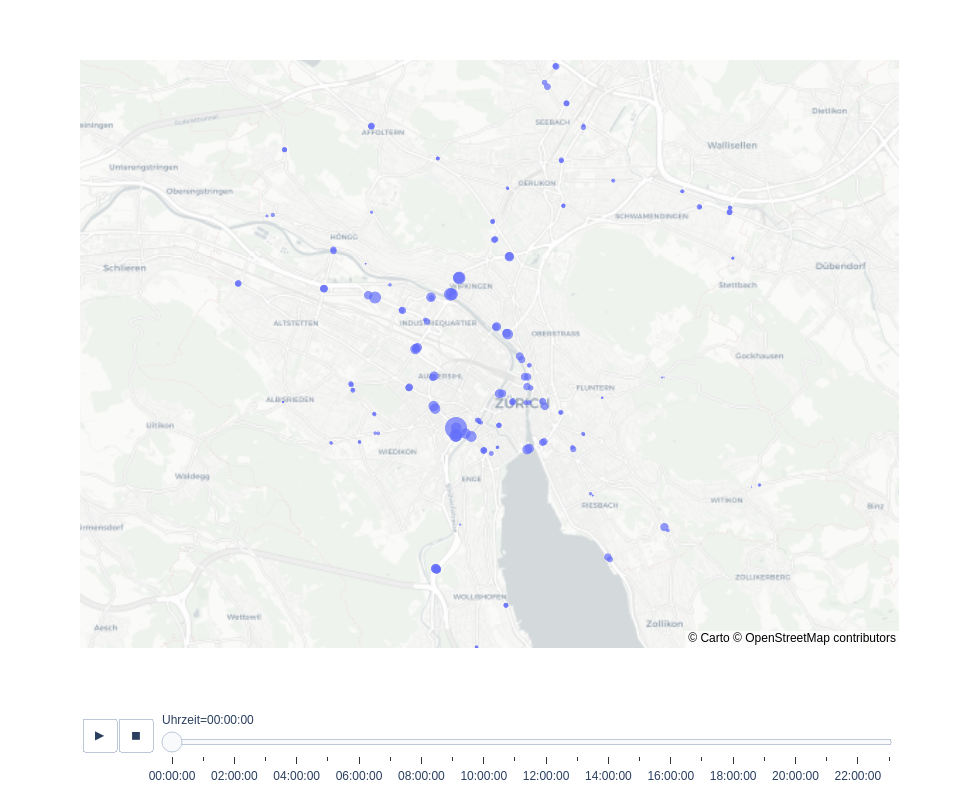

In [9]:
fig = px.scatter_mapbox(miv_data, lat="lat", lon="lon", size="AnzFahrzeuge",
                        animation_frame='Uhrzeit',
                        hover_data=['AnzFahrzeuge','ZSName','Richtung','Zeit'],
                        #title='Verkehrsaufkommen am {}'.format(date),
                        color_continuous_scale=px.colors.diverging.Tealrose,#px.colors.sequential.Plasma_r,#px.colors.cyclical.IceFire, 
                        size_max=30, 
                        zoom=11.5
)
fig.update_layout(mapbox_style="carto-positron",height=800) #"open-street-map", "carto-positron", "carto-darkmatter", "stamen-terrain", "stamen-toner" or "stamen-watercolor" 

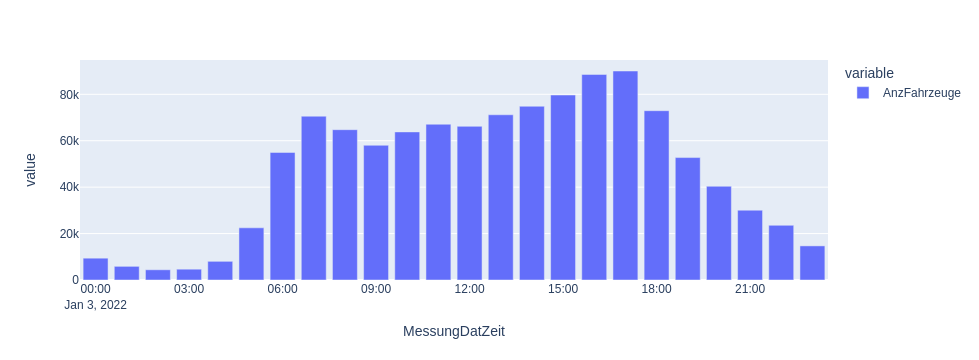

In [10]:
px.bar(miv_data.groupby(['MessungDatZeit'])['AnzFahrzeuge'].sum())

In [11]:
url_dates='''https://data.stadt-zuerich.ch/api/3/action/datastore_search_sql?sql=
SELECT 
    DISTINCT REPLACE("MessungDatZeit",'T',' ')::DATE AS datum
    from "{resource}"
WHERE "AnzFahrzeuge" IS NOT NULL
ORDER BY 1 DESC'''

In [12]:
# Load available date for datepicker
dates = pd.DataFrame()
for resource in resources:
    error_status, df_dates = download_data(url_dates.format(resource=resources[resource]))
    df_dates = extract_data(df_dates)
    dates = pd.concat([dates, df_dates])
dates

datum
0   2023-02-16
1   2023-02-15
2   2023-02-14
3   2023-02-13
4   2023-02-12
..         ...
78  2021-01-05
79  2021-01-04
80  2021-01-03
81  2021-01-02
82  2021-01-01

[213 rows x 1 columns]

In [ ]:
px.bar(dates.datum)